<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/CLV_CUSTOMER_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [152]:
import pandas as pd
import numpy as np
import datetime as dt
import tensorflow as tf
from tensorflow import feature_column as tfc
from six import iteritems
import lifetimes
from lifetimes import ParetoNBDFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from sklearn.metrics import mean_squared_error, r2_score

In [153]:
data = pd.read_excel("Retail_cleaned_dataset.xlsx")

In [154]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2019-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2019-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2019-12-01 07:45:00,1.25,13085,United Kingdom


In [155]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['date'] = data['InvoiceDate'].dt.date
data['TotalPrice'] = data['Price']*data['Quantity']

In [156]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,date,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2019-12-01 07:45:00,6.95,13085,United Kingdom,2019-12-01,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom,2019-12-01,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom,2019-12-01,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2019-12-01 07:45:00,2.10,13085,United Kingdom,2019-12-01,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2019-12-01 07:45:00,1.25,13085,United Kingdom,2019-12-01,30.0


In [157]:
threshold_date = dt.date(2021,9,9)
predict_date = dt.date(2021,12,9)

In [158]:
latest_order = data.groupby('CustomerID').agg({'date':'max'}).reset_index()
latest_order.columns = ['CustomerID','latestorder']
latest_order.head()

,CustomerID,latestorder
0,12346,2021-01-18
1,12347,2021-12-07
2,12348,2021-09-25
3,12349,2021-11-21
4,12350,2021-02-02


In [159]:
t1 = data.groupby(['CustomerID','date']).agg({'TotalPrice':'sum','Quantity':'sum'}).reset_index()
t1 = pd.merge(t1,latest_order,on='CustomerID',how='left')
t1.head()

,CustomerID,date,TotalPrice,Quantity,latestorder
0,12346,2019-12-14,90.0,20,2021-01-18
1,12346,2019-12-18,23.5,6,2021-01-18
2,12346,2020-01-04,45.0,10,2021-01-18
3,12346,2020-01-14,22.5,5,2021-01-18
4,12346,2020-01-22,22.5,5,2021-01-18


In [160]:
t2 = data[data['date']<threshold_date]
t2 = t2.groupby(['CustomerID','date']).agg({'TotalPrice':'sum'}).reset_index()
t2['TotalPrice'] = t2['TotalPrice'].round(2)
t2['flag'] = np.where(t2['TotalPrice']>0,1,0)
t2 = t2.groupby('CustomerID').agg({'flag':'sum'}).reset_index()
t2 = t2[t2['flag']>1]
t2.head()

,CustomerID,flag
0,12346,8
1,12347,6
2,12348,4
3,12349,3
6,12352,6


In [161]:
t3 = pd.merge(t1,t2['CustomerID'],on='CustomerID',how='inner')
t3['datediff'] =  (predict_date - t3['latestorder']).dt.days
t3 = t3[(t3['datediff']<=90) & 
        (((t3['Quantity']>0) & (t3['TotalPrice']>0)) | 
         ((t3['Quantity']<0) & (t3['TotalPrice']<0)))]        
t3 = t3[['CustomerID','date','TotalPrice','Quantity']]
#t3.columns = ['customer_id','order_date','order_value','order_qty_articles']
t3.head()

,CustomerID,date,TotalPrice,Quantity
8,12347,2020-10-31,611.53,509
9,12347,2020-12-07,711.79,319
10,12347,2021-01-26,475.39,315
11,12347,2021-04-07,636.25,483
12,12347,2021-06-09,382.52,196


In [162]:
first_order = t3.groupby('CustomerID').agg({'date':'min'}).reset_index()
first_order.columns = ['CustomerID','date_min']
first_order.head()

,CustomerID,date_min
0,12347,2020-10-31
1,12348,2020-09-27
2,12349,2020-04-29
3,12352,2020-11-12
4,12356,2020-10-11


In [163]:
t4 = pd.merge(t3,first_order,on='CustomerID',how='inner')
t4['order_value_btyd'] = np.where(t4['date_min']==t4['date'],0,t4['TotalPrice'])
t4 = t4[t4['date']<=threshold_date]
t4.head()

,CustomerID,date,TotalPrice,Quantity,date_min,order_value_btyd
0,12347,2020-10-31,611.53,509,2020-10-31,0.00
1,12347,2020-12-07,711.79,319,2020-10-31,711.79
2,12347,2021-01-26,475.39,315,2020-10-31,475.39
3,12347,2021-04-07,636.25,483,2020-10-31,636.25
4,12347,2021-06-09,382.52,196,2020-10-31,382.52


In [164]:
def aggregations(x):
    d = {}
    d['monetary_dnn'] = x['TotalPrice'].sum()
    d['cnt_orders'] = x['date'].nunique()
    d['monetary_btyd'] = np.where(d['cnt_orders']==1,0,x['order_value_btyd'].sum()/(d['cnt_orders']-1))
    d['recency'] = (x['date'].max()-x['date'].min()).days
    d['T'] = (threshold_date-x['date'].min()).days
    d['avg_basket_size'] = x['Quantity'].mean()
    d['avg_basket_value'] = x['TotalPrice'].mean()
    d['cnt_returns'] = np.where(x['TotalPrice']<0,1,0).sum()
    return pd.Series(d, index=['monetary_dnn','cnt_orders','monetary_btyd','recency','T','avg_basket_size',
                               'avg_basket_value','cnt_returns'])

t5 = t4.groupby('CustomerID').apply(aggregations).reset_index()
t5.head()

,CustomerID,monetary_dnn,cnt_orders,monetary_btyd,recency,T,avg_basket_size,avg_basket_value,cnt_returns
0,12347,3402.39,6,558.1719999999999,275,313,349.833333,567.065000,0
1,12348,1709.40,4,495.74666666666667,190,347,624.250000,427.350000,0
2,12349,2671.14,3,801.31,182,498,331.000000,890.380000,0
3,12352,1905.61,6,352.37199999999996,130,301,73.666667,317.601667,0
4,12356,6313.38,5,1350.735,179,333,682.200000,1262.676000,0


In [165]:
target = t3.groupby('CustomerID').agg({'TotalPrice':'sum'}).reset_index()
target.columns = ['CustomerID','target_monetary']
target['target_monetary'] = target['target_monetary'].round(2)
target.head()

,CustomerID,target_monetary
0,12347,4921.53
1,12348,2019.40
2,12349,4428.69
3,12352,2849.84
4,12356,6371.73


In [166]:
t6 = pd.merge(t5,target,on='CustomerID',how='inner')
t6['frequency_btyd'] = t6['cnt_orders']-1
t6['time_between'] = (t6['recency']/t6['cnt_orders']).round(2)
t6['avg_basket_value'] = t6['avg_basket_value'].round(2)
t6['avg_basket_size'] = t6['avg_basket_size'].round(2)
t6['frequency_dnn'] = t6['cnt_orders']
t6['has_returned'] = np.where(t6['cnt_returns']>0,1,0)
t6['frequency_btyd_clipped'] = np.where(t6['cnt_orders']>600,600,t6['cnt_orders'])
t6['monetary_btyd_clipped'] = np.where(t6['monetary_btyd']>100000,100000,t6['monetary_btyd'])
t6['target_monetary_clipped'] = np.where(t6['target_monetary']>100000,100000,t6['target_monetary'])
t6 = t6[['CustomerID','monetary_dnn','monetary_btyd','frequency_dnn','frequency_btyd','recency','T',
         'time_between','avg_basket_value','avg_basket_size','cnt_returns','has_returned',
         'frequency_btyd_clipped','monetary_btyd_clipped','target_monetary_clipped','target_monetary']]
t6 = t6[(t6['monetary_dnn']>0)&(t6['monetary_btyd']>0)]

t6.head()

,CustomerID,monetary_dnn,monetary_btyd,frequency_dnn,frequency_btyd,recency,T,time_between,avg_basket_value,avg_basket_size,cnt_returns,has_returned,frequency_btyd_clipped,monetary_btyd_clipped,target_monetary_clipped,target_monetary
0,12347,3402.39,558.1719999999999,6,5,275,313,45.83,567.07,349.83,0,0,6,558.1719999999999,4921.53,4921.53
1,12348,1709.40,495.74666666666667,4,3,190,347,47.50,427.35,624.25,0,0,4,495.74666666666667,2019.40,2019.40
2,12349,2671.14,801.31,3,2,182,498,60.67,890.38,331.00,0,0,3,801.31,4428.69,4428.69
3,12352,1905.61,352.37199999999996,6,5,130,301,21.67,317.60,73.67,0,0,6,352.37199999999996,2849.84,2849.84
4,12356,6313.38,1350.735,5,4,179,333,35.80,1262.68,682.20,0,0,5,1350.735,6371.73,6371.73


In [167]:
first_order = t3.groupby('CustomerID').agg({'date':'min'}).reset_index()
first_order.columns = ['CustomerID','date']
first_order.head()

,CustomerID,date
0,12347,2020-10-31
1,12348,2020-09-27
2,12349,2020-04-29
3,12352,2020-11-12
4,12356,2020-10-11


count    1949.000000
mean        8.464341
std        13.052979
min         1.000000
25%         2.000000
50%         5.000000
75%        10.000000
max       205.000000
Name: frequency_btyd, dtype: float64
0.15033350436121087


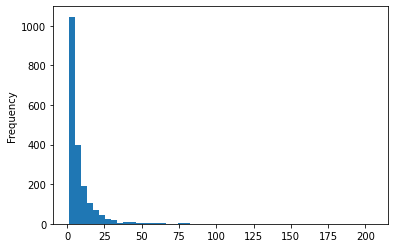

In [168]:
t6['frequency_btyd'].plot(kind='hist', bins=50)
print(t6['frequency_btyd'].describe())
print(sum(t6['frequency_btyd'] == 1)/float(len(t6)))

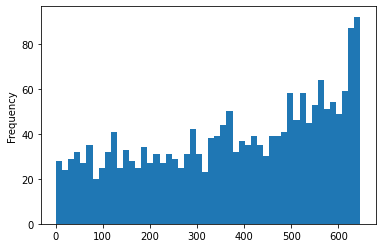

In [169]:
t6['recency'].plot(kind='hist', bins=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



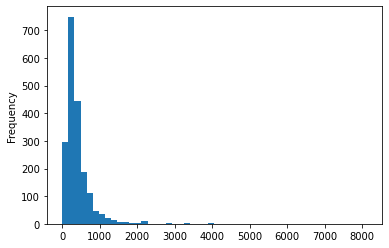

In [170]:
t6['monetary_btyd']= t6['monetary_btyd'].apply(np.int)
t6['monetary_btyd'].plot(kind='hist', bins=50)

Probabilistic Model

In [171]:
from datetime import datetime
from lifetimes import ParetoNBDFitter, GammaGammaFitter
import math
import numpy as np
import os
import pandas as pd
import tensorflow as tf

PENALIZER_COEF = 0.01
DISCOUNT_RATE = 0.01

In [172]:
summary = t6[['CustomerID', 'frequency_btyd', 'recency', 'T', 'monetary_btyd']]
summary.columns = ['CustomerID', 'frequency', 'recency', 'T', 'monetary_value']
summary = summary.set_index('CustomerID')
summary.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12347,5,275,313,558
12348,3,190,347,495
12349,2,182,498,801
12352,5,130,301,352
12356,4,179,333,1350


In [173]:
actual_df = t6[['CustomerID', 'frequency_btyd', 'monetary_dnn', 'target_monetary']]
actual_df.columns = ['CustomerID', 'train_frequency', 'train_monetary', 'act_target_monetary']
actual_df.head()

,CustomerID,train_frequency,train_monetary,act_target_monetary
0,12347,5,3402.39,4921.53
1,12348,3,1709.40,2019.40
2,12349,2,2671.14,4428.69
3,12352,5,1905.61,2849.84
4,12356,4,6313.38,6371.73


In [180]:
import inspect

In [183]:
def paretonbd_model(summary):
    paretof = ParetoNBDFitter(penalizer_coef=PENALIZER_COEF)
    paretof.fit(summary['frequency'], summary['recency'], summary['T'])
    return paretof
print(paretonbd_model(summary))

<lifetimes.ParetoNBDFitter: fitted with 1949 subjects, alpha: 89.97, beta: 1956.76, r: 1.56, s: 0.10>


In [184]:
def predict_value(summary, actual_df, fitter, ggf, time_days, time_months):
    ltv = pd.DataFrame(data=np.zeros([actual_df.shape[0], 6]),
                       columns=['CustomerID',
                              'actual_total',
                              'predicted_num_purchases',
                              'predicted_value',
                              'predicted_total',
                              'error'], dtype=np.float32)

    predicted_purchases = fitter.predict(time_days,
                                           summary['frequency'],
                                           summary['recency'],
                                           summary['T'])

    predicted_CLV = ggf.customer_lifetime_value(fitter,
                                                summary['frequency'],
                                                summary['recency'],
                                                summary['T'],
                                                summary['monetary_value'],
                                                time=time_months,
                                                discount_rate=DISCOUNT_RATE)

    ltv['CustomerID'] = actual_df['CustomerID']
    ltv['actual_total'] = actual_df['act_target_monetary']
    ltv['predicted_purchases'] = predicted_purchases.values
    ltv['predicted_CLV'] = predicted_CLV.values
    ltv['predicted_total'] = actual_df['train_monetary'] + ltv['predicted_CLV']
    ltv['error'] = ltv['actual_total'] - ltv['predicted_total']

    mse = pd.Series.sum(ltv['error'] * ltv['error']) / ltv.shape[0]
    rmse = math.sqrt(mse)

    return ltv, rmse
print(predict_value)

<function predict_value at 0x7ff957f86e60>


In [187]:
time_days = (predict_date - threshold_date).days
time_months = int(math.ceil(time_days / 30.0))

In [189]:
ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(summary['frequency'], summary['monetary_value'])
ggf

<lifetimes.GammaGammaFitter: fitted with 1949 subjects, p: 2.33, q: 3.48, v: 458.88>

In [190]:
## paretonbd_model
paretonbd_ltv, paretonbd_rmse = predict_value(summary,
                                            actual_df,
                                            paretonbd_model(summary),
                                            ggf,
                                            time_days,
                                            time_months)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



In [191]:
paretonbd_ltv

,CustomerID,actual_total,predicted_num_purchases,predicted_value,predicted_total,error,predicted_purchases,predicted_CLV
0,12347,4921.53,0.0,0.0,4418.520996,503.009004,1.475953,1016.130996
1,12348,2019.40,0.0,0.0,2280.144529,-260.744529,0.928792,570.744529
2,12349,4428.69,0.0,0.0,3118.353605,1310.336395,0.517641,447.213605
3,12352,2849.84,0.0,0.0,2571.896116,277.943884,1.417046,666.286116
4,12356,6371.73,0.0,0.0,8039.742384,-1668.012384,1.161305,1726.362384
...,...,...,...,...,...,...,...,...
1944,18273,357.00,0.0,0.0,446.734584,-89.734584,0.549553,140.734584
1945,18276,1656.52,0.0,0.0,1576.884175,79.635825,0.647758,256.224175
1946,18277,1180.05,0.0,0.0,1368.290709,-188.240709,0.598171,298.620709
1947,18283,2664.90,0.0,0.0,2084.297490,580.602510,2.010278,378.097490


In [193]:
# Assuming 5% of Profit Margin
paretonbd_ltv["CLV"] = paretonbd_ltv["predicted_CLV"]*0.05

In [194]:
paretonbd_ltv

,CustomerID,actual_total,predicted_num_purchases,predicted_value,predicted_total,error,predicted_purchases,predicted_CLV,CLV
0,12347,4921.53,0.0,0.0,4418.520996,503.009004,1.475953,1016.130996,50.806550
1,12348,2019.40,0.0,0.0,2280.144529,-260.744529,0.928792,570.744529,28.537226
2,12349,4428.69,0.0,0.0,3118.353605,1310.336395,0.517641,447.213605,22.360680
3,12352,2849.84,0.0,0.0,2571.896116,277.943884,1.417046,666.286116,33.314306
4,12356,6371.73,0.0,0.0,8039.742384,-1668.012384,1.161305,1726.362384,86.318119
...,...,...,...,...,...,...,...,...,...
1944,18273,357.00,0.0,0.0,446.734584,-89.734584,0.549553,140.734584,7.036729
1945,18276,1656.52,0.0,0.0,1576.884175,79.635825,0.647758,256.224175,12.811209
1946,18277,1180.05,0.0,0.0,1368.290709,-188.240709,0.598171,298.620709,14.931035
1947,18283,2664.90,0.0,0.0,2084.297490,580.602510,2.010278,378.097490,18.904875


In [195]:
#exporting the result to csv
paretonbd_ltv.to_excel("customer_lifetime_value_prediction.xlsx")

In [192]:
paretonbd_rmse

3167.1257435061516

In [196]:
b1 = t3[t3['date']<threshold_date]
b1 = b1.groupby('CustomerID').agg({'TotalPrice':'mean','date':'nunique'}).reset_index()
b1.columns = ['CustomerID','avg_basket_value','cnt_orders']

b2 = t3.groupby('CustomerID').agg({'TotalPrice':'mean'}).reset_index()
b2.columns = ['CustomerID','target_monetary']

feature_days = (threshold_date - t3['date'].min()).days
target_days = (predict_date - threshold_date).days

b3 = pd.merge(b1,b2,on='CustomerID',how='inner')
b3['predicted_monetary'] = b3['avg_basket_value']*(b3['cnt_orders']*(1+target_days/feature_days))
b3['target_monetary'] = b3['target_monetary'].round(2)
b3 = b3[['CustomerID','predicted_monetary','target_monetary']]

benchmark_rmse = round(np.sqrt(np.power(b3['predicted_monetary']-b3['target_monetary'],2).sum()/b3.shape[0]),2)

In [197]:
benchmark_rmse,paretonbd_rmse

(22562.44, 3167.1257435061516)

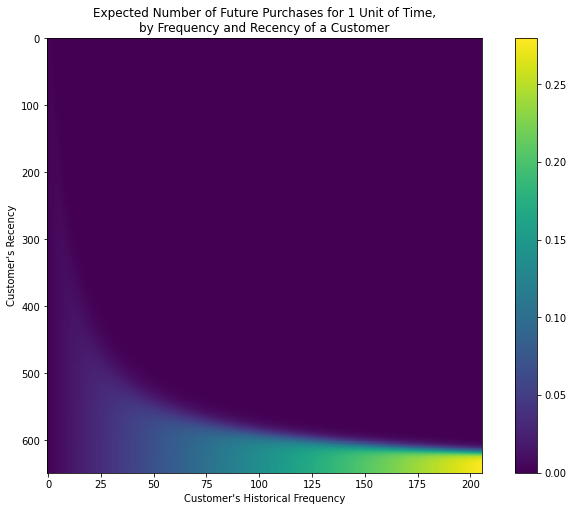

In [198]:
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(paretonbd_model(summary))

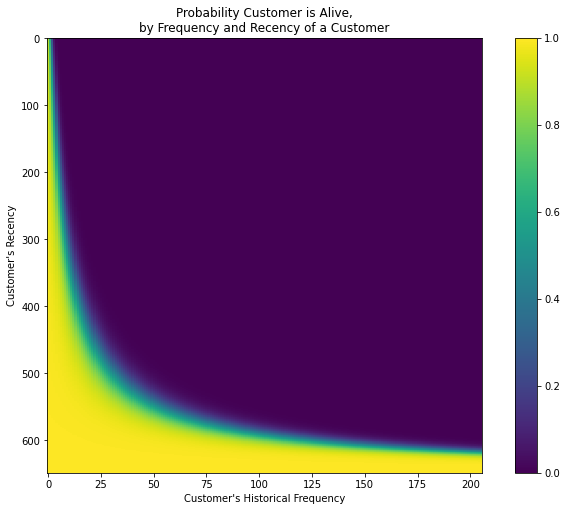

In [199]:
plt.figure(figsize=(12,8))
plot_probability_alive_matrix(paretonbd_model(summary))

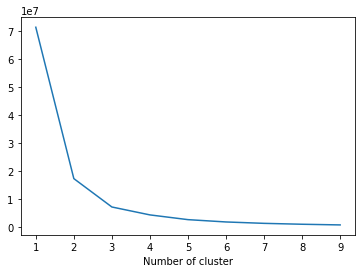

In [200]:
from sklearn.cluster import KMeans
MYSEED = 199
sse={}
t6_recency = t6[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(t6_recency)
    t6_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Recency Cluster

In [201]:
kmeans = KMeans(n_clusters=4,random_state=MYSEED)
kmeans.fit(t6[['recency']])
t6['RecencyCluster'] = kmeans.predict(t6[['recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

t6_cust = order_cluster('RecencyCluster', 'recency',t6,False)

t6_cust.groupby('RecencyCluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,653.0,583.998469,42.093472,506.0,547.00,587.0,624.00,647.0
1,494.0,427.890688,49.069105,346.0,382.25,427.5,474.75,505.0
2,413.0,263.285714,50.493734,176.0,220.00,266.0,304.00,345.0
3,389.0,88.969152,49.701159,1.0,44.00,91.0,130.00,175.0


Frequency cluster

In [202]:
kmeans = KMeans(n_clusters=4,random_state=MYSEED)
kmeans.fit(t6[['frequency_btyd']])
t6['FrequencyCluster'] = kmeans.predict(t6[['frequency_btyd']])

#order the frequency cluster
t6_cust = order_cluster('FrequencyCluster', 'frequency_btyd',t6,True)

#see details of each cluster
t6_cust.groupby('FrequencyCluster')['frequency_btyd'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1547.0,4.356173,2.885789,1.0,2.00,4.0,6.00,11.0
1,352.0,18.264205,5.752846,12.0,14.00,16.5,22.00,34.0
2,42.0,51.261905,14.240203,35.0,41.00,44.0,60.75,83.0
3,8.0,147.000000,35.286582,105.0,111.75,157.0,163.75,205.0


Monetary Cluster

In [203]:
#apply clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4,random_state=MYSEED)
kmeans.fit(t6[['target_monetary']])
t6['RevenueCluster'] = kmeans.predict(t6[['target_monetary']])


#order the cluster numbers
t6_cust = order_cluster('RevenueCluster', 'target_monetary',t6,True)

#show details of the dataframe
t6_cust.groupby('RevenueCluster')['target_monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1916.0,4531.199525,5362.026219,30.95,1349.485,2759.89,5399.7600,39918.19
1,26.0,79906.008077,32022.881934,43515.05,55785.985,66855.02,108149.5175,147142.77
2,5.0,243483.248000,60359.554785,172132.87,195640.690,244784.25,291420.8100,313437.62
3,2.0,554794.780000,37041.449321,528602.52,541698.650,554794.78,567890.9100,580987.04


Overall score based on RFM

In [204]:
t6_cust['OverallScore'] = t6_cust['RecencyCluster'] + t6_cust['FrequencyCluster'] + t6_cust['RevenueCluster']
t6_cust.groupby('OverallScore')['recency','frequency_btyd','target_monetary'].mean()

,recency,frequency_btyd,target_monetary
OverallScore,,,
0,262.327411,3.474619,2341.824873
1,565.346505,7.057751,4461.122918
2,122.346341,4.895122,2966.897902
3,426.146497,7.388535,6039.409703
4,597.916058,20.485401,12913.294380
5,484.312500,42.750000,156164.135625
6,441.407407,18.592593,8400.639815
7,428.000000,18.000000,144458.370000


In [205]:
t6_cust['Segment'] = 'Low-Value'
t6_cust.loc[t6_cust['OverallScore']>3,'Segment'] = 'Mid-Value' 
t6_cust.loc[t6_cust['OverallScore']>5,'Segment'] = 'High-Value' 

In [206]:
t6_cust.head(10)

,CustomerID,monetary_dnn,monetary_btyd,frequency_dnn,frequency_btyd,recency,T,time_between,avg_basket_value,avg_basket_size,...,has_returned,frequency_btyd_clipped,monetary_btyd_clipped,target_monetary_clipped,target_monetary,RecencyCluster,FrequencyCluster,RevenueCluster,OverallScore,Segment
0,12347,3402.39,558,6,5,275,313,45.83,567.07,349.83,...,0,6,558.1719999999999,4921.53,4921.53,0,0,0,0,Low-Value
1,12348,1709.40,495,4,3,190,347,47.50,427.35,624.25,...,0,4,495.74666666666667,2019.40,2019.40,0,0,0,0,Low-Value
2,12349,2671.14,801,3,2,182,498,60.67,890.38,331.00,...,0,3,801.31,4428.69,4428.69,0,0,0,0,Low-Value
3,12352,1905.61,352,6,5,130,301,21.67,317.60,73.67,...,0,6,352.37199999999996,2849.84,2849.84,2,0,0,2,Low-Value
4,12356,6313.38,1350,5,4,179,333,35.80,1262.68,682.20,...,0,5,1350.735,6371.73,6371.73,0,0,0,0,Low-Value
5,12358,3203.87,591,4,3,582,641,145.50,800.97,232.75,...,0,4,591.3466666666667,3887.07,3887.07,1,0,0,1,Low-Value
6,12359,6059.09,662,9,8,546,644,60.67,673.23,232.78,...,0,9,662.3,8873.39,8873.39,1,0,0,1,Low-Value
7,12360,3209.11,515,7,6,544,565,77.71,458.44,281.14,...,0,7,515.185,4252.89,4252.89,1,0,0,1,Low-Value
8,12362,1877.35,436,5,4,619,648,123.80,375.47,197.80,...,0,5,436.8375,5356.23,5356.23,1,0,0,1,Low-Value
9,12370,3577.28,753,5,4,395,578,79.00,715.46,444.80,...,0,5,753.5799999999999,4316.56,4316.56,3,0,0,3,Low-Value


In [207]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [208]:
t6_cust.groupby('Segment').CustomerID.count()/t6_cust.CustomerID.count()*100

Segment
High-Value     2.821960
Low-Value     82.298615
Mid-Value     14.879425
Name: CustomerID, dtype: float64

In [210]:
t6_cust.to_excel("Segmentation_result.xlsx")

In [209]:
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
t6_graph  = t6_cust.query("target_monetary < 50000 and frequency_btyd < 2000")

plot_data = [
    go.Scatter(
        x=t6_graph.query("Segment == 'Low-Value'")['frequency_btyd'],
        y=t6_graph.query("Segment == 'Low-Value'")['target_monetary'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'Mid-Value'")['frequency_btyd'],
        y=t6_graph.query("Segment == 'Mid-Value'")['target_monetary'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'High-Value'")['frequency_btyd'],
        y=t6_graph.query("Segment == 'High-Value'")['monetary_btyd'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#Revenue Recency

t6_graph = t6_cust.query("target_monetary < 50000 and frequency_btyd < 2000")

plot_data = [
    go.Scatter(
        x=t6_graph.query("Segment == 'Low-Value'")['recency'],
        y=t6_graph.query("Segment == 'Low-Value'")['target_monetary'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'Mid-Value'")['recency'],
        y=t6_graph.query("Segment == 'Mid-Value'")['target_monetary'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'High-Value'")['recency'],
        y=t6_graph.query("Segment == 'High-Value'")['target_monetary'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Revenue vs Frequency
t6_graph = t6_cust.query("target_monetary < 50000 and frequency_btyd < 2000")

plot_data = [
    go.Scatter(
        x=t6_graph.query("Segment == 'Low-Value'")['recency'],
        y=t6_graph.query("Segment == 'Low-Value'")['frequency_btyd'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'Mid-Value'")['recency'],
        y=t6_graph.query("Segment == 'Mid-Value'")['frequency_btyd'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'High-Value'")['recency'],
        y=t6_graph.query("Segment == 'High-Value'")['frequency_btyd'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)